# Smooth criminals: agent-based modeling of street crime

Research consistently shows that people living in poverty commit more crimes than people living in high-income households. This can be due to a variety of factors, such as employment accessibility, residential instability, and general distrust, but the most commonly cited factor is income and wealth inequality which is the factor we investigate in our model. Our model is based off of one generated by Groff in her paper, *Simulation for theory testing and experimentation: An example using routine activity theory and street robbery*, in which agents interact in a world based on various rules: no crimes may be committed in the presence of authority, and criminals only commit crimes if certain conditions are satisfied. In our model, the agents are called `Citizens`, inhabit a graph-like world called `CrimeWorld` where each node is a street intersection, and can have two different roles: some are offenders (agents who commit crimes) and some are police (agents who prevent crimes). The offender agents share sets of characteristics, and for each time step, these characteristics help to determine whether they commit a crime or not.

In [1]:
from __future__ import print_function, division

import random
import thinkplot
import numpy as np
from Cell2D import Cell2D, Cell2DViewer
from thinkstats2 import Cdf
from thinkstats2 import RandomSeed
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='html5')

In our simulated world, `CrimeWorld`, there are two types of agents: police officers and regular citizens. Regular citizens can have a variety of roles: some are offenders (agents who commit crimes), some are guardians (agents who prevent crimes), and some are targets (agents against whom crimes are committed).

The `Citizen` class represents every type of citizen, including police officers. For the purposes of the simulation, the `Citizen` class contains properties of all types of agents. More specifically, police officers are just citizens with the `isPopo` boolean set to `true`; offenders are just citizens who use the `decideToOffend`, `pickChump`, and `rob` functions; and targets are just citizens who use the `getRobbed` function.

A variety of factors affect an offender's decision to commit a crime. Consider a bunch of agents at a single node; some might be police, some might be guardians, and some might be offenders trying to find a guardian to make into a target. The first factor the offenders must consider is whether there are police at the node. The presence of a police officer is an absolute dealbreaker; no offender will commit a crime if they know someone is nearby who can catch them and stick them in jail for it.

If there are no police officers, however, the second factor the offenders must consider is the guardianship of other agents present; we'll call this variable `G`.

`G = (N`<sub>agents</sub>` - 2) + P`

`G` depends on two other variables. `N`<sub>agents</sub> is the total number of agents present at a given node, and we subtract 2 to account for the offender and their potential target. `P` is a randomly selected number between -2 and 2 that represents the offender's perception of the capability of the guardians who are present.

If `G < 1`, the offender determines that there are not capable guardians present, so they should commit the crime.

If `G == 1`, the offender isn't sure if there are capable guardians present, so they make a random decision to commit the crime.

And finally, if `G > 1`, the offender determines that there are capable guardians present and they should not commit the crime.

Now, let's assume `G <= 1` and the offender has decided to commit the crime. Which agent should the offender offend? The offender must consider the suitability of the potential targets in the node, a variable we'll call `S`.

`S = (W`<sub>target</sub>` - W`<sub>offender</sub>`) + P`

`S` depends on several other variables. `W`<sub>target</sub> is the wealth of the potential target and `W`<sub>offender</sub> is the wealth of the offender. And like our equation for `G`, `P` represents a randomly selected number, this time between -1 and 1, which represents the offender's perception of the wealth of the target.

If `S >= 0`, the offender determines that the target is suitably wealthy and robs them.

If `S < 0`, the offender determines that the target is not suitably wealthy, so they move on to the next potential target in the node.

We define the equations for finding `G` and `S` as `decideToOffend` and `pickChump`, respectively.

In [2]:
class Citizen():
    """
    Represents a citizen in CrimeWorld.
    """
    def __init__(self, loc, home, wealth, time_from_home):
        self.loc = loc
        self.home = home
        self.wealth = wealth
        self.time_from_home = 24*time_from_home
        
        self.isPopo = False
        self.timeAway = 0
        self.isHome = False
        self.timeAtHome = 0 

    def step(self, n):
        self.wealth += 5 # Get paid
        if (self.isHome):
            if (self.timeAtHome >= 24 - self.time_from_home):
                if (random.randint(0, 5) <= 2):
                    self.isHome = False # Leave home
                    self.timeAtHome = 0
                else:
                    self.timeAtHome += 1
            else:
                self.timeAtHome += 1
        else:
            if (self.timeAway >= self.time_from_home):
                self.isHome = True # Go home
                self.timeAway = 0
                self.loc = self.home
            else:
                self.timeAway += 1
                directions = [[0,5], [0,-5], [5,0], [-5,0]] # Possible directions for movement
                index = np.random.randint(4)
                new_loc = np.add(self.loc, directions[index])
                while (new_loc[0] < 0 or new_loc[1] < 0 or
                      new_loc[0] >= n or new_loc[1] >= n):
                    index = np.random.randint(4)
                    new_loc = np.add(self.loc, directions[index])
                self.loc = new_loc

    def decideToOffend(self, agents):
        capability = random.randint(-2, 2)
        G = len(agents) - 2 + capability
        if G > 1:
            return False
        elif G == 1:
            return random.choice([True, False])
        return True

    def pickChump(self, agents):
        if (agents != []):
            return max(agents, key= lambda x: x.wealth)    
    
    def getRobbed(self):
        self.wealth -= 1

    def rob(self):
        self.wealth += 1

    def setHome(self, state):
        self.isHome = state
    
    def setPopo(self, state):
        self.isPopo = state    

Now, we need to create the world that all these citizens live in. `CrimeWorld` is based on `Cell2D` and LA's real-world properties. In `CrimeWorld`, we keep track of the locations of all citizens and crimes in an array, where each cell represents the location of a street intersection.

In [3]:
class CrimeWorld(Cell2D):
    """
    Represents the world in which our simulation takes place.
    Partially based on SugarScape code from Think Complexity by Allen Downey.
    """

    def __init__(self, n, **params):
        """
        Initializes the attributes.
  
        n: number of rows and columns
        params: dictionary of parameters
            -num_citizens
            -num_police
            -prop_criminals
        """
        self.params = params
        self.array = np.zeros(shape=(n,n))
        self.make_agents(n)
        self.n = n
        self.agent_count_seq = [] # track variables
        self.total_robs = 0
        self.rob_count_seq = []
        self.total_wealth = 0
  
    def make_locs(self, n, m):
        """
        Makes array where each row is an index in an `n` by `m` grid.
    
        n: int number of rows
        m: int number of cols
    
        returns: NumPy array
        """
        left = np.repeat(np.arange(m), n)
        right = np.tile(np.arange(n), m)
        return np.transpose([left, right])

    def make_agents(self, n):
        """Makes the agents."""
        locs = self.make_locs(n, n)
        np.random.shuffle(locs)
                
        # make the agents
        num_citizens = self.params.get('num_citizens', 1000)
        num_police = self.params.get('num_police', 200)
        time_from_home = self.params.get('time_from_home', 0.3)
        self.citizens = [Citizen(locs[i], locs[i], 5, time_from_home = time_from_home) #everyone starts out with wealth of 5
                            for i in np.random.choice(range(len(locs)), num_citizens)]
        for citizen in random.sample(self.citizens, num_police):
            citizen.setPopo(True)  # set police
  
    def step(self):
        num_citizens = float(self.params.get('num_citizens', 1000))
        prop_criminals = self.params.get('prop_criminals', 0.2)
        for citizen in self.citizens:
            citizen.step(self.n)
            self.total_wealth = 0
            self.total_wealth += citizen.wealth
            
        potential_criminals = random.sample(self.citizens, int(prop_criminals * num_citizens))
        for potential_criminal in potential_criminals:
            average_wealth = self.total_wealth/num_citizens
            
            citizens_in_node = [x for x in self.citizens if np.array_equal(x.loc,potential_criminal.loc) and not x.isHome]
            if potential_criminal.decideToOffend(citizens_in_node) and not potential_criminal.isHome:
                target = potential_criminal.pickChump(citizens_in_node)
                if (target != None and not target.isHome):
                    potential_criminal.rob()
                    target.getRobbed()
                    self.array[target.loc[0]][target.loc[1]] += 1
                    self.total_robs += 1
    
        self.rob_count_seq.append(self.total_robs)

Now that the world and its inhabitants have been set up, we can run the simulation and view the results using the `CrimeWorldViewer` below.

In [4]:
class CrimeWorldViewer(Cell2DViewer):
    """
    Generates visualization and animation of CrimeWorld.
    Partially based on SugarScapeViewer code from Think Complexity by Allen Downey.
    """

    cmap = plt.get_cmap('Greens')

    options = dict(interpolation='none', alpha=0.8,
                   vmin=0, vmax=7)

    def draw(self, grid=False):
        """Draws the array and any other elements.

        grid: boolean, whether to draw grid lines
        """
        self.draw_array(self.viewee.array, origin='lower')
        self.draw_agents()

    def draw_agents(self):
        """Plots the agents.
        """
        self.points = plt.plot(0,0,'.', color='red')[0]
        plt.show()

    def animate_func(self, i):
        """Draws one frame of the animation."""
        Cell2DViewer.animate_func(self, i)
        xs, ys = self.get_coords()
        self.points.set_data(np.array([xs, ys]))
        return self.im, self.points

    def get_coords(self):
        """Gets the coordinates of the agents.

        Transforms from (row, col) to (x, y).

        returns: tuple of sequences, (xs, ys)
        """
        agents = self.viewee.citizens
        new_array = np.zeros((1,2))
        rows, cols = np.transpose([new_array for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

In [10]:
RandomSeed(100)
env = CrimeWorld(127, num_citizens=1000, prop_criminals=0.2, num_police=200, time_from_home = 0.3)

for i in range(100):
    env.step()

print(env.total_robs)

6292


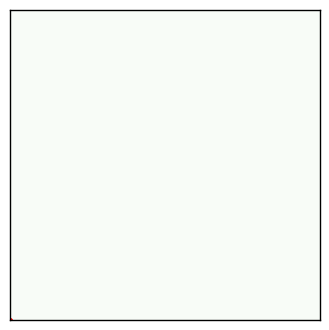

In [5]:
viewer = CrimeWorldViewer(env)
viewer.draw()

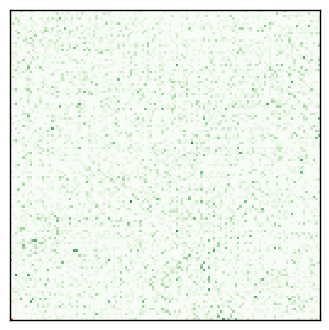

In [6]:
for i in range(100):
    env.step()
viewer.draw()

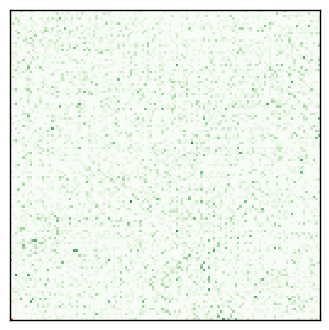

In [7]:
anim = viewer.animate(frames=200)
anim

Note how the concentration of robberies increases in certain areas, forming a pattern across the world. The movement of the agents is random, but since they always return to their homes at the end of the day, they tend not to stray far from their homes. We think this is the reason behind the patterns in these results.

Now, let's take a look at the number and the rate of robberies over time.

0.3 0.7434434868869738
0.4 0.8980097960195921
0.5 1.1145762291524584
0.6 1.2841465682931366
0.7 1.436728873457747


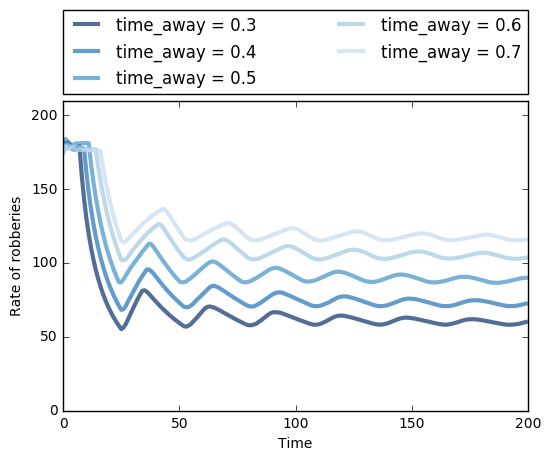

In [8]:
RandomSeed(100)
times_from_home = [0.3, 0.4, 0.5, 0.6, 0.7]
n = 127
results = []
plt.clf()
for time in times_from_home:
    env = CrimeWorld(n, num_citizens=1000, prop_criminals=0.2, num_police=200, time_from_home = time)
    viewer = CrimeWorldViewer(env)
    for i in range(200):
        env.step()
    results.append((env.total_robs / n**2))
    print(time, env.total_robs/ n**2)


    thinkplot.plot(np.divide(env.rob_count_seq,range(1,201)), label="time_away = %.1f" % time)
    
plt.axis((0, 200, 0, 210))
plt.xlabel("Time")
plt.ylabel("Rate of robberies")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [9]:
for i in range(len(results)-1):
    for j in range(i+1, len(results)):
        print("I", times_from_home[i], "  J", times_from_home[j], "  Mean Difference", 36.5*(results[i] - results[j]))
    print()

I 0.3   J 0.4   Mean Difference -5.6416702833405665
I 0.3   J 0.5   Mean Difference -13.546345092690185
I 0.3   J 0.6   Mean Difference -19.73566247132494
I 0.3   J 0.7   Mean Difference -25.30491660983322

I 0.4   J 0.5   Mean Difference -7.904674809349619
I 0.4   J 0.6   Mean Difference -14.093992187984373
I 0.4   J 0.7   Mean Difference -19.663246326492654

I 0.5   J 0.6   Mean Difference -6.189317378634755
I 0.5   J 0.7   Mean Difference -11.758571517143036

I 0.6   J 0.7   Mean Difference -5.569254138508282



It might be interesting to note that the rate of robberies increases as the amount of time the agents spend away from home increases, even though the number of agents and the number of time steps are fixed. This behavior is the same as that in Groff's experiment, even if the mean difference results shown above aren't exactly the same; this can be attributed to the fact that Groff's experiment was run for a year's worth of time, while our experiment is run for approximately 10 days' worth of time.

We investigate the effects of adding punishment as a deterrent to crime in `CrimeWorld` in `crimeworldnotebook-punishment.ipynb`.

We now slightly extend Groff's model with `ShrewdCitizen` and its accompanying world, `ShrewdCrimeWorld`, to investigate the effects of wealth on the number of crimes committed.

In [16]:
class ShrewdCitizen(Citizen):
    """
    Represents a citizen in CrimeWorld.
    """
    def __init__(self, loc, home, wealth, time_from_home):
        Citizen.__init__(self, loc, home, wealth, time_from_home)

    def decideToOffend(self, agents):
        if self.wealth <= 0:
            return True
        else:
            capability = random.randint(-2, 2)
            G = len(agents) - 2 + capability
            if G > 1:
                return False
            elif G == 1:
                return random.choice([True, False])
            return True

In [17]:
class ShrewdCrimeWorld(CrimeWorld):
    def __init__(self, n, **params):
        CrimeWorld.__init__(self, n, **params)
        
    def make_agents(self, n):
        """Makes the agents."""
        locs = self.make_locs(n, n)
        np.random.shuffle(locs)
                
        # make the agents
        num_citizens = self.params.get('num_citizens', 1000)
        num_police = self.params.get('num_police', 200)
        time_from_home = self.params.get('time_from_home', 0.3)
        self.citizens = [ShrewdCitizen(locs[i], locs[i], 5, time_from_home = time_from_home) #everyone starts out with wealth of 5
                            for i in np.random.choice(range(len(locs)), num_citizens)]
        for citizen in random.sample(self.citizens, num_police):
            citizen.setPopo(True)  # set police

In [18]:
RandomSeed(100)
env = ShrewdCrimeWorld(127, num_citizens=1000, prop_criminals=0.2, num_police=200, time_from_home = 0.3)

for i in range(100):
    env.step()

print(env.total_robs)

6292


So, for this experiment, 6292 crimes were committed. We'll see how this compares to the number of crimes committed when punishment is brought into the picture in `crimeworldnotebook-punishment.ipynb`.